In [1]:
# Import necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Load numpy arrays
train_x = np.load('train_x.npy')
train_y = np.load('train_y.npy')
print(train_x.shape)
print(train_y.shape)

(3799, 128, 128, 11)
(3799, 128, 128, 1)


In [3]:
# Reshape data
# Moving the axis of train_x from the 0th position to the second-last position
array_X = np.moveaxis(train_x, 0, -2)
print("Shape of array_X:", array_X.shape)

# Moving the axis of train_y in a similar manner as array_X
array_y = np.moveaxis(train_y, 0, -2)
print("Shape of array_y:", array_y.shape)


Shape of array_X: (128, 128, 3799, 11)
Shape of array_y: (128, 128, 3799, 1)


In [4]:
# Split data into training and testing sets
# Creating a list of indices from 0 to 3798
indices = list(range(3799))

# Splitting the list of indices into training and testing sets
# test_size=0.25 - 25% of the data will be used for testing
train_X, test_x = train_test_split(indices, test_size=0.25, random_state=42)

# Create dummy data
# Extracting the training and testing subsets of array_X using the indices obtained above
# The resulting arrays will have the same dimensions as array_X, but only containing the specified indices
train_X_dummy = array_X[:,:,train_X,:]
test_X_dummy = array_X[:,:,test_x,:]

# Extracting the corresponding labels (array_y) for the training and testing subsets
train_y_dummy = array_y[:,:,train_X,:]
test_y_dummy = array_y[:,:,test_x,:]

# Printing the shapes
print("Shape of train_X_dummy:", train_X_dummy.shape)
print("Shape of train_y_dummy:", train_y_dummy.shape)
print("Shape of test_X_dummy:", test_X_dummy.shape)
print("Shape of test_y_dummy:", test_y_dummy.shape)


Shape of train_X_dummy: (128, 128, 2849, 11)
Shape of train_y_dummy: (128, 128, 2849, 1)
Shape of test_X_dummy: (128, 128, 950, 11)
Shape of test_y_dummy: (128, 128, 950, 1)


In [5]:
# Reshape data into 2D arrays
# The resulting shape will be [total_samples, 11], where total_samples = 128 * 128 * 950
X_train = np.reshape(train_X_dummy, [128*128*2849, 11])

# The resulting shape will be [total_samples, 11]
X_test = np.reshape(test_X_dummy, [128*128*950, 11])

# The resulting shape will be [total_samples, 1], where total_samples = 128 * 128 * 2849
y_train = np.reshape(train_y_dummy, [128*128*2849, 1])

# The resulting shape will be [total_samples, 1]
y_test = np.reshape(test_y_dummy, [128*128*950, 1])

# Printing the shapes
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (46678016, 11)
Shape of y_train: (46678016, 1)
Shape of X_test: (15564800, 11)
Shape of y_test: (15564800, 1)


In [6]:
# Remove unwanted variables from memory
del train_x, train_y, array_X, array_y, train_X_dummy, test_X_dummy, train_y_dummy, test_y_dummy

In [7]:
# Calculate class weights for imbalanced classes
labels, counts = np.unique(y_train, return_counts=True)
frequencies = np.asarray((labels, counts)).T
class_weight_dict = dict(zip(labels, 1 / counts))
(frequencies, class_weight_dict)

(array([[0.0000000e+00, 4.5608412e+07],
        [1.0000000e+00, 1.0696040e+06]]),
 {0.0: 2.192577983201871e-08, 1.0: 9.349254490446932e-07})

In [ ]:
# Initialize a RandomForestClassifier
RF = RandomForestClassifier(n_estimators=100, 
                            class_weight=class_weight_dict, 
                            max_depth=6, 
                            n_jobs=-1, 
                            verbose=1, 
                            random_state=0)

# Split data into batches and train the model
batch_size = 50000
num_batches = X_train.shape[0] // batch_size + 1

for i in range(num_batches):
    batch_start = i * batch_size
    batch_end = (i + 1) * batch_size
    batch_x = X_train[batch_start:batch_end]
    batch_y = y_train[batch_start:batch_end]
    RF.fit(batch_x, np.ravel(batch_y, order='C'))

In [9]:
# Predict
y_pred = RF.predict(X_test)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    9.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   27.2s finished


In [10]:
# Reshape predicted data
y_pred_reshaped = y_pred.reshape(128, 128, 950, 1)
print(y_pred_reshaped.shape)
x_test_reshaped = X_test.reshape(128, 128, 950, 11)
print(x_test_reshaped.shape)
y_test_reshaped = y_test.reshape(128, 128, 950, 1)
print(y_test_reshaped.shape)

(128, 128, 950, 1)
(128, 128, 950, 11)
(128, 128, 950, 1)


In [11]:
from sklearn.metrics import classification_report

# Reshape the true and predicted labels to 2D arrays
y_test_2d = y_test.reshape(-1)
y_pred_2d = y_pred.reshape(-1)

# Print classification report
print(classification_report(y_test_2d, y_pred_2d))


              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97  15191614
         1.0       0.30      0.88      0.45    373186

    accuracy                           0.95  15564800
   macro avg       0.65      0.92      0.71  15564800
weighted avg       0.98      0.95      0.96  15564800



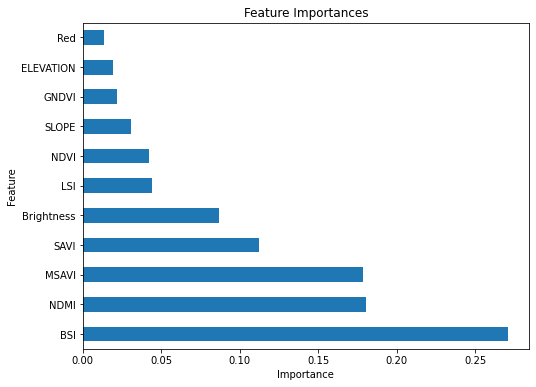

In [41]:
# Create a bar plot to visualize the feature importances
feat_importances = pd.Series(RF.feature_importances_, index=['Red', 'LSI', 'MSAVI', 'NDVI', 'SLOPE', 'ELEVATION', 'NDMI', 'GNDVI', 'SAVI', 'Brightness', 'BSI'])
ax = feat_importances.nlargest(11).plot(kind='barh', figsize=(8,6))
ax.set_xlabel("Importance")
ax.set_ylabel("Feature")
ax.set_title("Feature Importances")
plt.show()


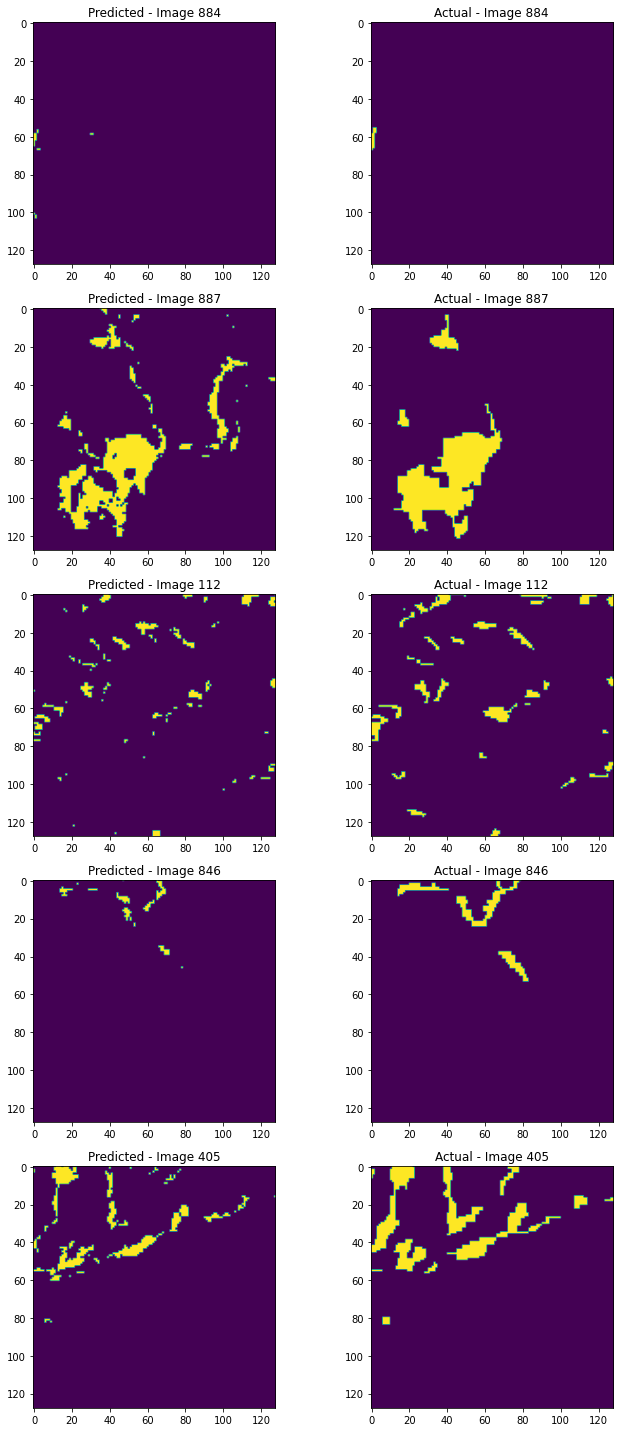

In [42]:
import random
# Randomly select 5 indices
random_indices = random.sample(range(y_pred_reshaped.shape[2]), 5)

# Create subplots
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))

# Plot the images
for i, idx in enumerate(random_indices):
    # Plot the predicted image
    axes[i][0].imshow(y_pred_reshaped[:, :, idx], cmap='viridis')
    axes[i][0].set_title(f"Predicted - Image {idx}")
    # Plot the actual image
    axes[i][1].imshow(y_test_reshaped[:, :, idx], cmap='viridis')
    axes[i][1].set_title(f"Actual - Image {idx}")

plt.tight_layout()
plt.show()


In [47]:
# too many false positives, what if we increase the threshold
# Calculate prediction probabilities
predicted_proba = RF.predict_proba(X_test)
# Set the threshold for classification
threshold = 0.97
# Apply the threshold to get binary predictions
y_pred = (predicted_proba[:, 1] >= threshold).astype('int')

# Restore the predicted data into images of size 128x128
y_pred_reshaped = y_pred.reshape(128, 128, 950, 1)
print(y_pred_reshaped.shape)
x_test_reshaped = X_test.reshape(128, 128, 950, 11)
print(x_test_reshaped.shape)
y_test_reshaped = y_test.reshape(128, 128, 950, 1)
print(y_test_reshaped.shape)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    6.6s


(128, 128, 950, 1)
(128, 128, 950, 11)
(128, 128, 950, 1)


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   20.7s finished


In [48]:
from sklearn.metrics import classification_report

# Reshape the true and predicted labels to 2D arrays
y_test_2d = y_test.reshape(-1)
y_pred_2d = y_pred.reshape(-1)

# Print classification report
print(classification_report(y_test_2d, y_pred_2d))


              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99  15191614
         1.0       0.73      0.49      0.58    373186

    accuracy                           0.98  15564800
   macro avg       0.86      0.74      0.79  15564800
weighted avg       0.98      0.98      0.98  15564800



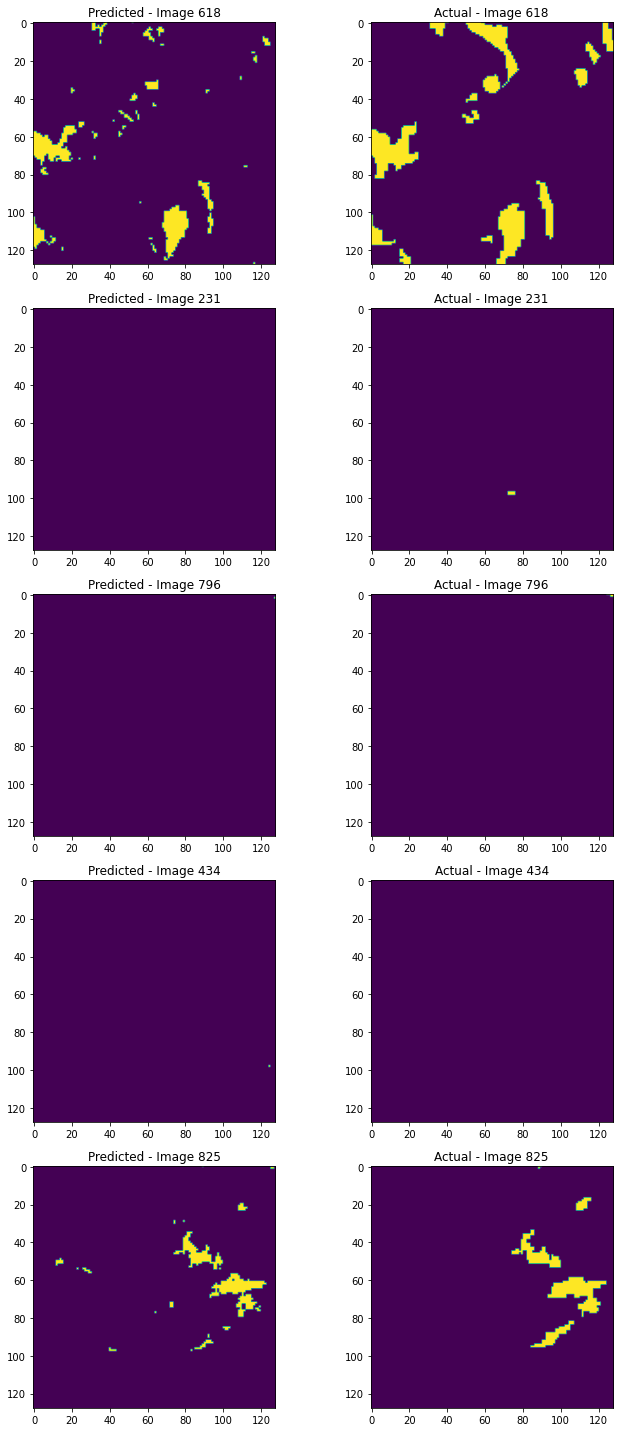

In [49]:
import random
# Randomly select 5 samples
random_indices = random.sample(range(y_pred_reshaped.shape[2]), 5)

# Create subplots
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))

# Plot the images
for i, idx in enumerate(random_indices):
    # Plot the predicted image
    axes[i][0].imshow(y_pred_reshaped[:, :, idx], cmap='viridis')
    axes[i][0].set_title(f"Predicted - Image {idx}")
    # Plot the actual image
    axes[i][1].imshow(y_test_reshaped[:, :, idx], cmap='viridis')
    axes[i][1].set_title(f"Actual - Image {idx}")

plt.tight_layout()
plt.show()


In [ ]:
#UNET implementation